In [42]:
# Standard code libraries
import numpy as np
import scipy
from scipy.signal import find_peaks

import pandas as pd
import matplotlib.pyplot as plt

# Custom code libraries from the ReSurfEMG
from resurfemg.postprocessing.baseline import moving_baseline
import resurfemg.preprocessing.envelope as evl
import resurfemg.postprocessing.quality_assessment as qa

%matplotlib widget

In [43]:
# Define EMG signal
fs_emg = 2048
t_emg = np.array([s_t/fs_emg for s_t in range(10*fs_emg)])
y_amps = [2, 5, 12]
y_sin = np.cos((0.5* t_emg - 0.5)* 2 * np.pi)
y_sin[y_sin < 0] = 0
y_emg = np.zeros((3, len(t_emg)))
y_env = np.zeros((3, len(t_emg)))
y_emg_baselines = np.zeros((3, len(t_emg)))
window_s = fs_emg // 5  # 200 ms --> Delay of 100 ms
for idx, y_amp in enumerate(y_amps):
    y_rand = np.random.normal(0, 1, size=len(y_sin))
    y_rand_baseline = np.random.normal(0, 1, size=len(y_sin)) / 10
    y_t = y_amp * y_sin * y_rand + y_rand_baseline
    y_emg[idx, :] = y_t

    # Get RMS signal and baseline
    y_env[idx, :] = evl.full_rolling_rms(y_t, window_s)
    y_emg_baselines[idx, :] = moving_baseline(y_env[idx, :], 5*fs_emg, fs_emg//2)

peaks_env, _ = find_peaks(y_env[1,:], prominence=0.1)

# Define ventilator
fs_vent = 100
t_vent = np.array([s_t/fs_vent for s_t in range(10*fs_vent)])
y_vent = np.zeros((3, len(t_vent)))
y_vent_baselines = np.zeros((3, len(t_vent)))
window_s = fs_emg // 5  # 200 ms --> Delay of 100 ms
for idx in range(3):
    match idx:
        case 0:
            y_block = 3*scipy.signal.square(
                (t_vent - 1)/2 * 2 * np.pi, duty=0.5)
            y_block[y_block < 0] = 0
            y_vent[idx, :] = y_block
            y_vent_baselines[idx, :] = moving_baseline(
                y_vent[idx, :], 5*fs_vent, fs_vent//2)
        case 1:
            y_sin = np.sin((0.5* t_vent - 0.5)* 2 * np.pi)
            y_vent[idx, :] = y_sin
        case _:
            y_sin = np.sin((0.5* t_vent - 0.5)* 2 * np.pi)
            y_sin[y_sin < 0] = 0
            y_vent[idx, :] = y_sin
    

# peaks_env, _ = find_peaks(y_env, prominence=0.1)


In [83]:
def time_series_df(
    y_data,
    data_labels,
    t_axis=None,
    fs=None,
):
    if type(y_data) is tuple:
        y_data_out = np.array([])
        for _, array in enumerate(y_data):
            
            y_data_out = np.append(y_data_out, array, axis=1)
        
        y_data = y_data_out

    print(y_data.shape)
    if len(y_data.shape) > 2:
        raise IndexError
    else:
        max_axis = np.argmax(y_data.shape)
        if max_axis == 0:
            y_data = y_data.T
    
    if t_axis is None and fs is None:
        t_vent = np.arange(y_data.shape[max_axis])
    elif t_axis is None:
        t_vent = np.array([x/fs for x in range(y_data.shape[1])])


    data = ()
    pd.DataFrame()
    print(t_vent)
    
    
    

In [84]:
a_mat = y_vent
data_labels = ['Pvent (cmH2O)', 'F (L/s)', 'Vvent (mL)']
a_tuple = (y_vent[0, :], y_vent[1, :], y_vent[2, :])
time_series_df(a_tuple, data_labels, fs=fs_vent)
type(a_mat)


AxisError: axis 1 is out of bounds for array of dimension 1

In [66]:
for _, x in enumerate(a_tuple):
    print(len(x))


1000
1000
1000


Text(0.5, 0, 't (s)')

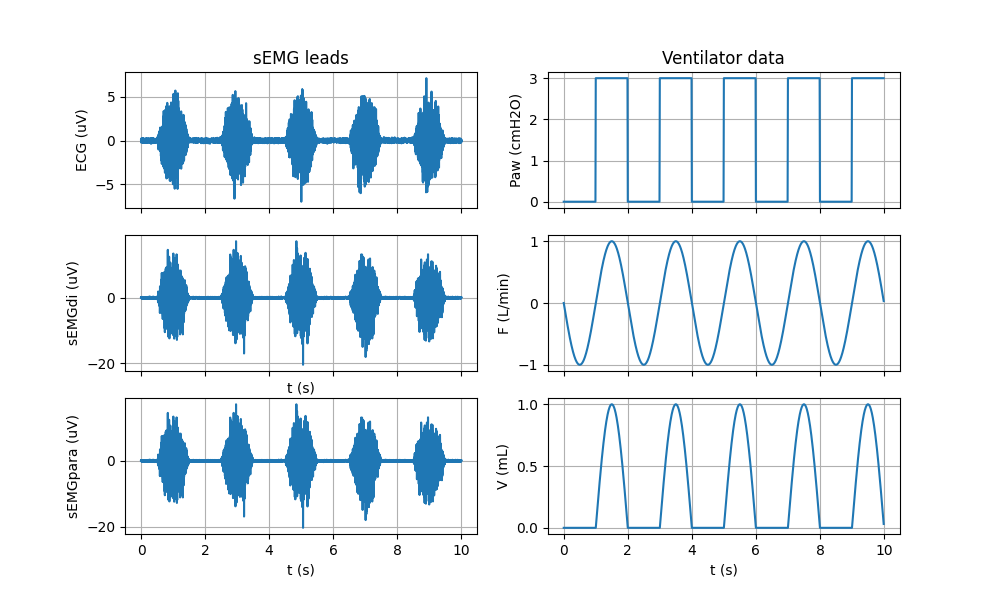

In [23]:
# Plot the raw data
fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(10, 6), sharex=True)

axis[0, 0].grid(True)
axis[0, 0].plot(t_emg, y_emg[0])
axis[0, 0].set(title='sEMG leads')
axis[0, 0].set_ylabel('ECG (uV)')
axis[1, 0].grid(True)
axis[1, 0].plot(t_emg, y_emg[1])
axis[1, 0].set_ylabel('sEMGdi (uV)')
axis[1, 0].set_xlabel('t (s)')
axis[2, 0].grid(True)
axis[2, 0].plot(t_emg, y_emg[1])
axis[2, 0].set_ylabel('sEMGpara (uV)')
axis[2, 0].set_xlabel('t (s)')

# axis[2, 0].axis('off')

axis[0, 1].set(title='Ventilator data')
axis[0, 1].grid(True)
axis[0, 1].plot(t_vent, y_vent[0])
axis[0, 1].set_ylabel('Paw (cmH2O)')
axis[1, 1].grid(True)
axis[1, 1].plot(t_vent, y_vent[1])
axis[1, 1].set_ylabel('F (L/min)')
axis[2, 1].grid(True)
axis[2, 1].plot(t_vent, y_vent[2])
axis[2, 1].set_ylabel('V (mL)')
axis[2, 1].set_xlabel('t (s)')